In [24]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

from diffusers import DDPMPipeline # https://huggingface.co/docs/diffusers/api/pipelines/ddpm

In [25]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

butterfly_pipeline = DDPMPipeline.from_pretrained(
    "/mnt/mydrive/datas/ddpm-butterflies-32px" # local loading
).to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
# create 8 images
images = butterfly_pipeline(batch_size=8).images

  0%|          | 0/1000 [00:00<?, ?it/s]

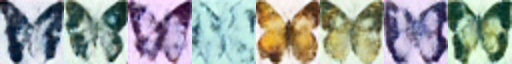

In [28]:
# view results
make_grid(images)

# Training 

In [30]:
'''
Load in some images from the training data
Add noise, in different amounts.
Feed the noisy versions of the inputs into the model
Evaluate how well the model does at denoising these inputs
Use this information to update the model weights, and repeat
'''

'\nLoad in some images from the training data\nAdd noise, in different amounts.\nFeed the noisy versions of the inputs into the model\nEvaluate how well the model does at denoising these inputs\nUse this information to update the model weights, and repeat\n'

## Step1: Downloading a training dataset

In [29]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

In [30]:
dataset = load_dataset("/mnt/mydrive/datas/dataset/smithsonian_butterflies_subset", split="train") # imageFoder 
# git lfs clone https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset
image_size = 32 
batch_size = 64
len(dataset)
# dataset[0]["image"] # (512 w , 283 h)
# dataset[0]["image"].convert("RGB") # (512 w , 283 h)
dataset[0:2]["image"]

Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/huggan--smithsonian_butterflies_subset-f47db2e462b3593d/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x179>]

In [31]:
# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1) # b, c, h, w
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

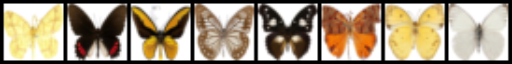

In [32]:
# grab a batch of images and visualize it
xb_visualize = next(iter(train_dataloader))["images"].to(device)[:8]   # torch.Size([64, 3, 32, 32])
show_images(xb_visualize).resize((8 * 64, 64), resample=Image.BILINEAR)

## Step2: Define the Scheduler

In [44]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.18.0.dev0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

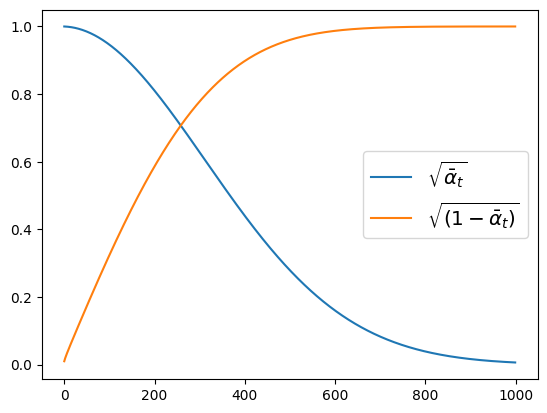

In [45]:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2') # better for small images

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");


Noisy X shape torch.Size([8, 3, 32, 32])
tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')


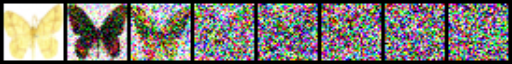

In [46]:
xb = xb_visualize

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise     = torch.randn_like(xb) # mean = 0 , std = 1

noisy_xb  = noise_scheduler.add_noise(xb, noise, timesteps) # xb: 64 
print("Noisy X shape", noisy_xb.shape)
print(timesteps)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.BILINEAR)

## Step3: Define Model UNet

In [47]:
from diffusers import UNet2DModel

# create a model
model = UNet2DModel(
    sample_size = image_size, # target image resolution
    in_channels = 3,
    out_channels = 3,
    layers_per_block=2, # how many resnet layers to use per Unet block
    block_out_channels = (64, 128,128, 256),
    down_block_types   = (
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),  
).to(device)

In [38]:
# with torch.no_grad():
#     model_prediction = model(noisy_xb, timesteps).sample
# model_prediction.shape  #  batchsize: 8 

# Step4: Create a Training Loop

In [48]:
import time
# 3090ti: Mem-Usage 3959MiB 16.1%    GPU-Utils: 37%   

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr = 4e-4)

losses = []

start_time = time.time()  # start timer at the beginning of each epoch

for epoch in range(30):

    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0] # 64

        # sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs, ), device = clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


end_time = time.time()  # stop timer at the end of each 5 epochs
elapsed_time = end_time - start_time

Epoch:5, loss: 0.1418487010523677
Epoch:10, loss: 0.11583478096872568
Epoch:15, loss: 0.10758984833955765
Epoch:20, loss: 0.08836300345137715
Epoch:25, loss: 0.07440325082279742
Epoch:30, loss: 0.07430716161616147


In [49]:
print(elapsed_time) # 195.62777495384216 # 3.26min

195.62777495384216


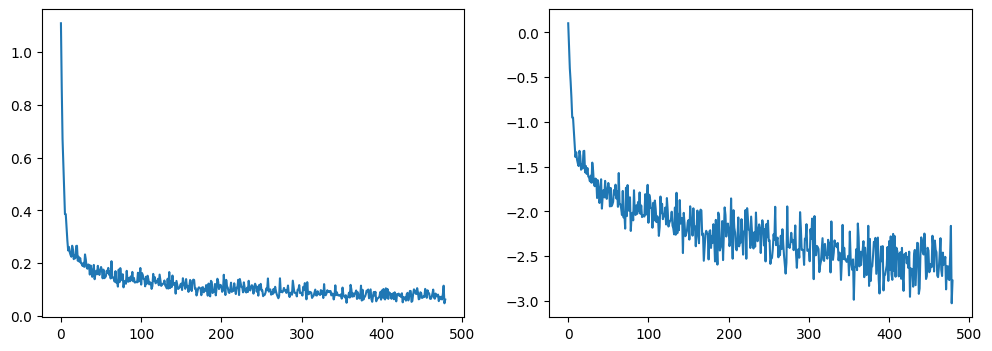

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

# Step6: Generate Images

  0%|          | 0/1000 [00:00<?, ?it/s]

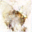

In [51]:
# 1. create a pipeline
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe()
pipeline_output.images[0]

In [52]:
pipeline_output.images[0].size

(32, 32)

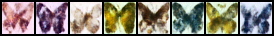

In [53]:
# 2. writing a sampling loop
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)


# Scaling up with Accelerate

In [3]:
from huggingface_hub import notebook_login

notebook_login() # huggingface-cli login  # login in from the terminal

In [ ]:
# !sudo apt -qq install git-lfs
# !git config --global credential.helper store